In [5]:
from tensorflow.keras.models import load_model
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
from webapp.utils import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
weigths_path = '../pretrained/model.h5'
model = load_model(weigths_path)

In [7]:
def sketchify(jc):

    jc = np.uint8(jc)
    
    scale_percent = 1

    width = int(jc.shape[1]*scale_percent)
    height = int(jc.shape[0]*scale_percent)

    dim = (width,height)
    resized = cv2.resize(jc,dim,interpolation = cv2.INTER_AREA)

    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    sharpened = cv2.filter2D(resized,-1,kernel_sharpening)



    gray = cv2.cvtColor(sharpened , cv2.COLOR_BGR2GRAY)
    inv = 255-gray
    gauss = cv2.GaussianBlur(inv,ksize=(15,15),sigmaX=0,sigmaY=0)

    def dodgeV2(image,mask):
        return cv2.divide(image,255-mask,scale=256)

    pencil_jc = 255 - dodgeV2(gray,gauss)
    img = np.zeros(jc.shape)
    img[:,:,0] = pencil_jc
    img[:,:,1] = pencil_jc
    img[:,:,2] = pencil_jc
    return img

In [101]:
def get_embeedings(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(256,256),interpolation = cv2.INTER_AREA)
    sketch_im = sketchify(img)/255

    output = model.predict(sketch_im[np.newaxis,:,:,:])
    class_ = output[1]
    embedding_vector = output[0][0]
    index = np.where(class_[0] > 0.0)[0]
    class_name = []
    for i in index:
        class_name.append(class_index[i])
    return class_name, embedding_vector

In [102]:
def cosine_similarity(a,b):
    return dot(a, b)/(norm(a)*norm(b))

Connected to AWS DataBase!
1242


/Users/chizhang/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


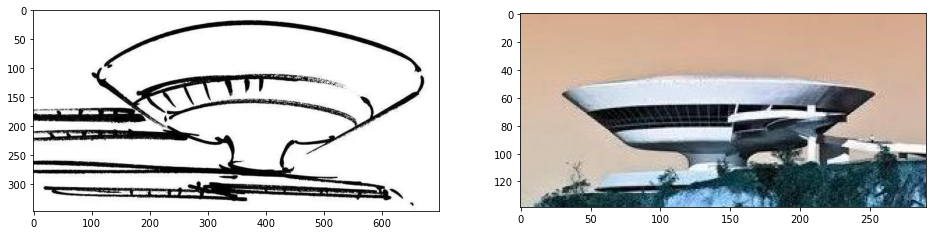

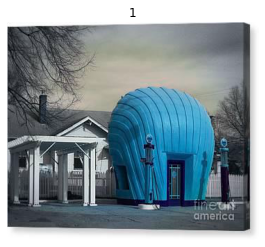

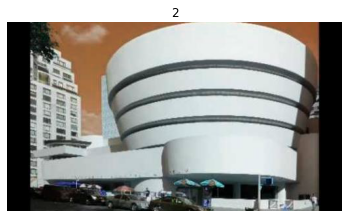

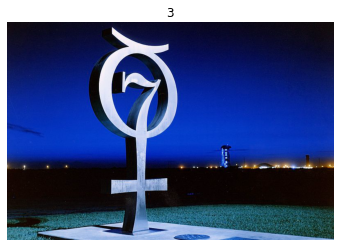

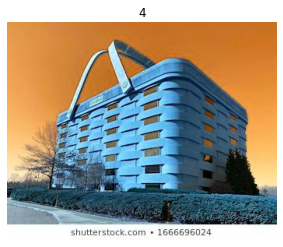

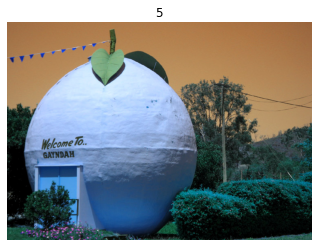

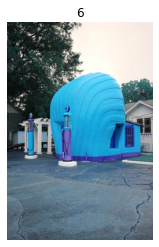

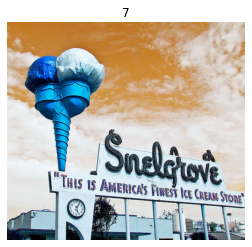

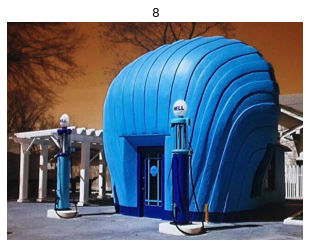

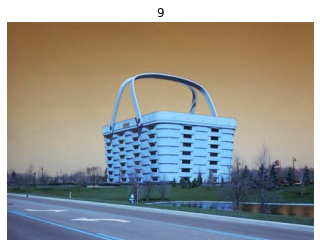

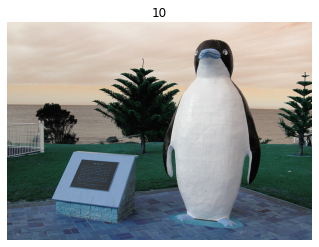

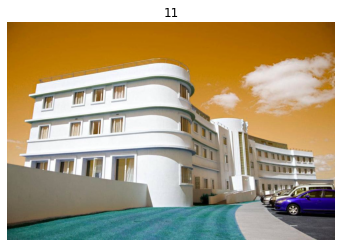

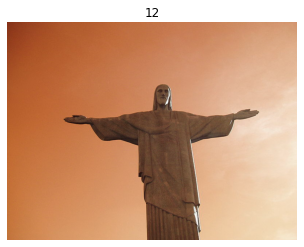

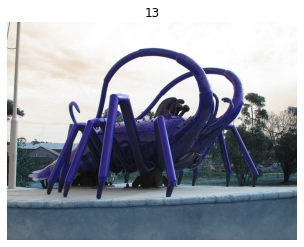

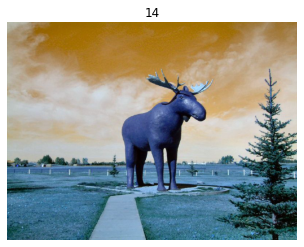

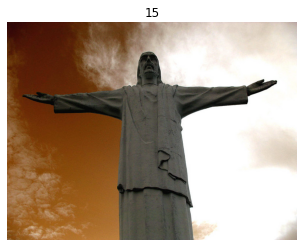

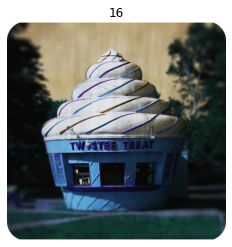

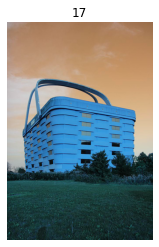

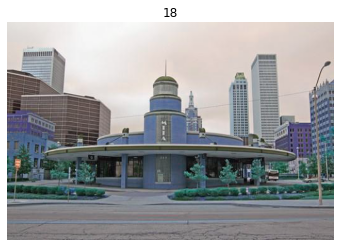

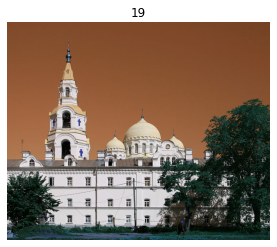

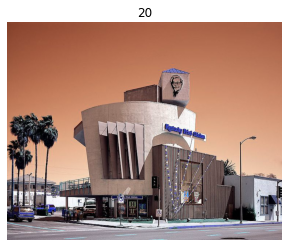

In [158]:
#sketch_file = './webapp/sample_images/test_image1.png'
#sketch_file = '../validation_image/Palladian architecture.png'
#sketch_file = '../extended_image/45-image.jpg'
sketch_file = '../extended_sketch/49-sketch.jpg'
image_file = '../extended_image/49-image.jpg'
class_name, embedding_vector = get_embeedings(sketch_file)
class_name, embedding_image = get_embeedings(image_file)
conn, cursor = connect()
if len(class_name) == 1:
    sql_query = f"select * from image_embeddings where style in (\'{class_name[0]}\')"
else:
    sql_query = f"select * from image_embeddings where style in {str(tuple(class_name))}"
    
df = pd.read_sql(sql_query,conn)

conn.close()

similarity = []
for i in range(len(df)):
    embeddings = np.fromstring(df.iloc[i,3], dtype=float, sep=',')
    similarity.append(cosine_similarity(embeddings,embedding_vector))

df['similarity'] = similarity

df = df.sort_values(by = 'similarity', ascending=False)

fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(cv2.imread(sketch_file))
ax[1].imshow(cv2.imread(image_file))

print(np.sum(df.similarity > cosine_similarity(embedding_vector,embedding_image)) + 1)

for i in range(20):
    f = '/Users/chizhang/Downloads/archive' + df.iloc[i,2]
    if df.iloc[i,4] < 0.5:
        continue
    
    plt.figure()
    plt.imshow(cv2.imread(f))
    plt.axis('off')
    plt.title(str(i+1))

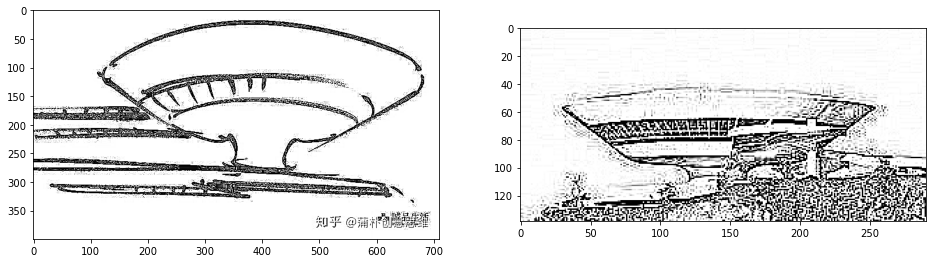

In [157]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(1-sketchify(cv2.imread(sketch_file))/255)
ax[1].imshow(1-sketchify(cv2.imread(image_file))/255)